In [1]:
import numpy as np
from tqdm import tqdm
import timeit
from matplotlib import pyplot as plt

import mala
from scipy.integrate import nquad

In [3]:
dim = 1
h = 0.2
n =1000
N_train = 100
N_test = 50

def f(x):
    a = 1 / np.sqrt(2)
    return 1/2 * (x-a)**2 - np.log(1 + np.exp(-2 * x * a))

def f_grad(x):
    a = 1 / np.sqrt(2)
    return x - a + 2 * a/(1 + np.exp(2* (x * a)))

def pi(x):
    a = 1 / np.sqrt(2)
    return 1/(2 * (2 * np.pi)**(dim/2)) * (np.exp(-(x-a)**2 /2) + np.exp(-(x+a)**2 / 2))


def local_weighted_estimator(X):
    return X.sum(axis=1).mean()

def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

In [4]:
def ULA_with_burnin(d, step, burn_in, n, f_grad):
    """ MCMC ULA
    Args:
        Md: dimension
        step: stepsize of the algorithm
        burn_in: burn-in period
        n: number of samples after the burn-in
        f_grad: gradient of the potential U
    Returns:
        traj: a numpy array of size (n, d), where the trajectory is stored
        traj_grad: numpy array of size (n, d), where the gradients of the potential U along the trajectory are stored
        traj_noise: numpy array of size (n, d), where the noises along trajectory are stored
    """
    traj = np.zeros((burn_in + n, d))
    traj_grad = np.zeros((burn_in + n, d))
    traj_noise = np.random.randn(burn_in + n, d)
    
    traj[0] = (np.random.normal(0,1,d)).reshape(d)
    traj_grad[0] = f_grad(traj[0])

    for i in range(1,burn_in + n):
        traj[i] = traj[i-1] - step/2*traj_grad[i-1] + np.sqrt(step) * traj_noise[i]
        traj_grad[i] = f_grad(traj[i])
    return traj[burn_in:], traj_grad[burn_in:], traj_noise[burn_in:]

In [5]:
np.random.seed(42)
X_ULA, _, _  = ULA_with_burnin(d=dim, step=h, burn_in=20000, n=100000,f_grad = f_grad)
X, G, Z , U, ac_rate = mala.MALA_with_burnin(d=dim, step=h, burn_in=20000, n=100000,f_grad = f_grad, f = f)

0.99492


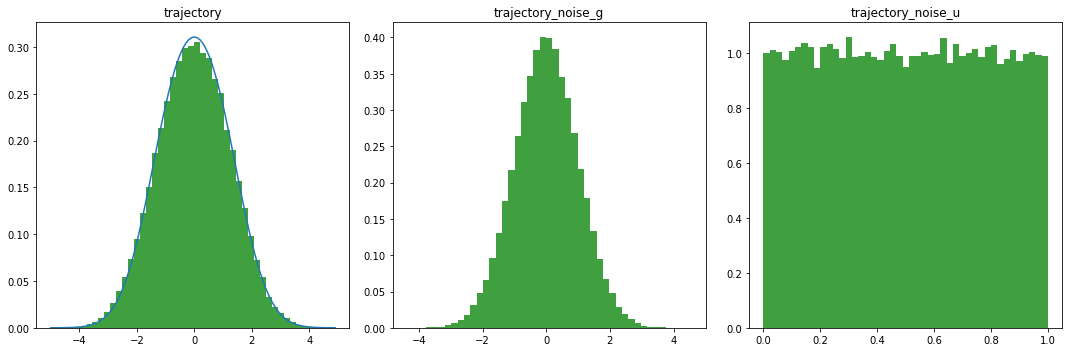

In [6]:
print (ac_rate)
mala.plot_distr(X, Z, U, 0, pi)

In [7]:
np.random.seed(123)

XX, GG, ZZ, UU = mala.generate_train_trajectories(X, N_train=N_train,d = dim, step = h, n = n, f_grad=f_grad, f = f)
XX_test, GG_test, ZZ_test, UU_test = mala.generate_test_trajetories(N_test=N_test, d =dim, step=h, 
                                                          burn_in=10000, n = n, f_grad=f_grad, f = f)

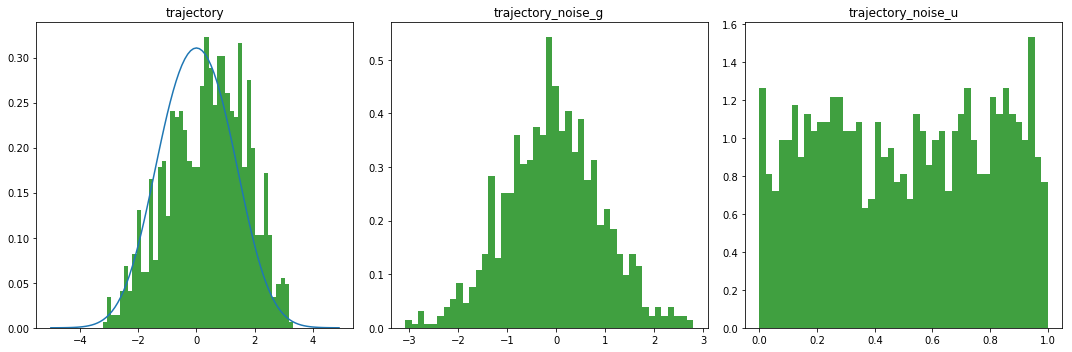

In [8]:
mala.plot_distr(XX[2], ZZ[0], UU[0], 0, pi)

In [9]:
def H(k, x): #Hermite
    if k==0:
        return 1.0
    if k ==1:
        return x
    if k==2:
        return (x**2 - 1)/np.sqrt(2)
    h = hermitenorm(k)(x) /  np.sqrt(math.factorial(k))
    return h

def L(k,x): #Shifted Legandre 
    if k==0:
        return 1.
    elif k==1:
        return np.sqrt(3) * (2*x - 1)
    elif k ==2:
        return np.sqrt(5) * (6*x**2 - 6*x +1)
    else:
        return None
    
def Hermite_val(k_vec,x_vec):
    P = 1.0
    d = x_vec.shape[0]
    for i in range(d):
        P = P * H(k_vec[i],x_vec[i])
    return P

def phi_val(k_vec, x_vec, uni):
    return H(k_vec[:-1], x_vec) * L(k_vec[-1], uni)

### Check orthonormality

In [11]:
def check_exp_leg(k_1, k_2, n=2000000):
    xi = np.random.uniform(size=n)
    s = np.zeros_like(xi)
    for i in range(n):
        s[i] = L(k_1, xi[i]) * L(k_2, xi[i])
    return s.mean()

def check_exp_hermite(k_1, k_2, n=2000000):
    xi = np.random.randn(n)
    s = np.zeros_like(xi)
    for i in range(n):
        s[i] = H(k_1, xi[i]) * H(k_2, xi[i])
    return s.mean()

### Approximate $Q_{p,l}$

In [10]:
def generate_X_poly(train_traj, r, max_deg):
    N_train = train_traj.shape[0]
    N = train_traj.shape[1]
    d = train_traj.shape[2]
    X = np.empty((N_train * (N-r) ,d+1 + int(d*(d+1)/2)))
    all_points = train_traj[:, :N-r].reshape(-1,d)
    poly = PolynomialFeatures(max_deg)
    X = poly.fit_transform(all_points)
    return X, poly.powers_

def generate_y_mean(train_traj, r, f_target = "sum"):
    N_train = train_traj.shape[0]
    N = train_traj.shape[1]
    y = np.zeros(N_train * (N-r))
    if f_target == "sum":
        y = train_traj[:, r:].sum(axis = 2).reshape(-1)
    elif f_target == "sum_squared":
        y = np.square(train_traj[:, r:]).sum(axis = 2).reshape(-1)
    elif f_target == "sum_4th":
        y = (train_traj[:, r:]**4).sum(axis = 2).reshape(-1)
    elif f_target == "exp_sum":
        y = np.exp(train_traj[:, r:].sum(axis =2)).reshape(-1)
    else:
        raise Exception('unrecognized target function')
    return y

In [11]:
def G_pml_fit_mean(train_traj, f_target="sum", max_deg = 1):
    N_train = train_traj.shape[0]
    N = train_traj.shape[1]
    d = train_traj.shape[2]
    Betas = np.zeros((N, d+ 1 + (max_deg-1) * int(d*(d+1)/2)))
    for r in tqdm(range(N)):
        # Linear Regression
        if 0 < max_deg < 3:
            X, degrees = generate_X_poly(train_traj, r, max_deg)
        else:
            raise Exception('max_deg should be 1 or 2')
        y = generate_y_mean(train_traj, r, f_target)

        beta = np.linalg.inv(X.T @ X) @ X.T @ y
        Betas[r] = beta
    return Betas, degrees

def G_pml_predict(x, pml, Betas, max_deg = 1):
    poly = PolynomialFeatures(max_deg)
#     x_pol = poly.fit_transform(x.reshape(1,-1))
    x_pol = poly.fit_transform(x.reshape(1,-1))
    beta = Betas[pml]
    return (x_pol @ beta)

### Compute 

### $a_{p,l,k_1, k_2}(x) = \mathbb{E}_{u, \xi} \left[ H_{k_1}(\xi) L_{k_2}(u) Q_{p,l}\left( x + \mathbb{1}\left\{u \leq \alpha(x, x - \gamma \mu(x) + \sqrt{\gamma} \xi) \right\}(-\gamma \mu(x) + \sqrt{\gamma}\xi) \right)\right] = \\
=  \int_0^1 \int_{-\infty}^{\infty} H_{k_1}(\xi) L_{k_2}(u) Q_{p,l} \left( x + \mathbb{1}\left\{u \leq \alpha(x, x - \gamma \mu(x) + \sqrt{\gamma} \xi) \right\}(-\gamma \mu(x) + \sqrt{\gamma}\xi) \right) \varphi(\xi) d\xi du$

In [68]:
from scipy.integrate import nquad
from scipy.stats import norm

def integrand(ksi, u, k_vec, x, x_grad, p, l):# x - gaussian, y - uniform
    next_point = np.array([x - h/2 * x_grad + np.sqrt(h) * ksi])
    logratio = -f(next_point)+f(x) + (1./(2*h))*(np.linalg.norm(next_point-x+h/2*x_grad)**2 \
                      - np.linalg.norm(x-next_point+h/2*f_grad(next_point))**2)
    if np.log(u)<=logratio:
         x = next_point
    return G_pml_predict(x, p-l, Betas) * phi_val(k_vec, ksi, u)* norm.pdf(ksi)

def bounds_u(k_vec, x, x_grad, p, l):
    return (0,1)

def bounds_ksi(u, k_vec, x, x_grad, p, l):
    return (-1, 1)

options_ksi = {'limit':100}
options_u = {'limit':50}
def a_plk_explicit(k_vec, x, x_grad, p, l):
    return nquad(integrand, ranges = [bounds_ksi, bounds_u], args = (k_vec, x,x_grad, p, l), opts=[options_ksi,options_u])[0]

In [20]:
def a_plk_explicit_2(k_vec, x, x_grad, p, l):
    ksi = np.random.randn(500)
    u = np.random.uniform(size=ksi.shape[0])
    s = np.empty_like(ksi)
    for i in range(ksi.shape[0]):
        point = x
        next_point = np.array([x - h/2 * x_grad + np.sqrt(h) * ksi[i]])
        logratio = -f(next_point)+f(x) + (1./(2*h))*(np.linalg.norm(next_point-x+h/2*x_grad)**2 \
                          - np.linalg.norm(x-next_point+h/2*f_grad(next_point))**2)
        if np.log(u[i])<=logratio:
             point = next_point
        s[i] = G_pml_predict(point, p-l, Betas) * phi_val(k_vec, ksi[i], u[i])
    return s.mean()

In [88]:
a_plk_explicit(k_comb[0], XX[5, 5], GG[5,5], 5, 5 )

0.0888058332459803

In [21]:
a_plk_explicit_2(k_comb[0], XX[5, 5], GG[5,5], 5, 5 )

0.4794239567344197

In [15]:
def M_bias(k_vec, traj, traj_grad, traj_noise_g, traj_noise_u, step, degrees, Betas, n_tilde):
    N = traj.shape[0]
    S = 0
    for p in range(N):
        for l in range (p+1):
            if (p-l<n_tilde):   #TRUNCATED
                s = a_plk_explicit_2(k_vec, traj[l-1], traj_grad[l-1], p, l)* \
                                    phi_val(k_vec,traj_noise_g[l], traj_noise_u[l])
                S = S + s
    return S/N

def estimator_bias(k_vec, test_traj, test_traj_grad, test_traj_noise_g, test_traj_noise_u, 
                   step, degrees, Betas, n_tilde, n_jobs = -1):
    N_test = test_traj.shape[0]
    M_results = Parallel(n_jobs = n_jobs)(delayed(M_bias)(k_vec, test_traj[i], test_traj_grad[i], test_traj_noise_g[i],
                                                          test_traj_noise_u[i], step, degrees, Betas,n_tilde)
                                          for i in range(N_test))
    return np.array(M_results).reshape(-1)

In [16]:
import numpy as np
from scipy.special import comb
from scipy.special import hermitenorm
from tqdm import tqdm
from joblib import Parallel, delayed
from itertools import product
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt
import math
import ZVnbrosse

In [17]:
f_target = 'sum'
deg = 1
Betas, degrees = G_pml_fit_mean(XX,f_target, max_deg = deg)

100%|██████████| 1000/1000 [00:01<00:00, 676.24it/s]


In [18]:
k_comb = np.zeros((dim + 1,dim + 1), dtype = np.int16)
for i in range(dim+1):
    k_comb[i,i] = 1

In [23]:
i_test = 7
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[i_test])
print ("mean of target function =", p)
for i in range(len(k_comb)):
    p = p - M_bias(k_comb[i], XX_test[i_test],GG_test[i_test], ZZ_test[i_test],UU_test[i_test], h, degrees,Betas,5)
    print ("            (k = {}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))

mean of target function = 0.06473375068623136
            (k = [1 0]) = [0.03819369] [Time:365.9860108909779]
            (k = [0 1]) = [0.03540482] [Time:732.9091862629866]


In [22]:
i_test = 4
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[i_test])
print ("mean of target function =", p)
for i in range(len(k_comb)):
    p = p - M_bias(k_comb[i], XX_test[i_test],GG_test[i_test], ZZ_test[i_test],UU_test[i_test], h, degrees,Betas,10)
    print ("            (k = {}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))

mean of target function = -0.12117607939514155
            (k = [1 0]) = [-0.05504038] [Time:732.2720876570093]
            (k = [0 1]) = [-0.0472819] [Time:1461.1783822809812]


In [28]:
P_test = estimator(XX_test)

100%|██████████| 50/50 [00:00<00:00, 34882.77it/s]


In [25]:
def ZVpolyOne(traj, traj_grad):
    n, d = traj.shape
    samples = traj.sum(axis = 1).reshape(-1,1)
    cov1 = np.var(traj_grad)
    A = 1 / cov1
    covariance = np.cov(np.concatenate((-traj_grad, samples), axis=1), rowvar=False)
    paramZV1 = -np.dot(A,covariance[:d, d:])
    ZV1 = samples - np.dot(traj_grad, paramZV1)
    mean_ZV1 = np.mean(ZV1, axis = 0)
    return mean_ZV1

res_zv_1 = []
for i in range (XX_test.shape[0]):
    res_zv_1.append(ZVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim)))
res_zv_1 = np.array(res_zv_1).reshape(-1)

res_zv_2 = []
for i in range (XX_test.shape[0]):
    res_zv_2.append(ZVnbrosse.ZVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_zv_2 = np.array(res_zv_2).reshape(-1)

res_cv_1 = []
for i in range (XX_test.shape[0]):
    res_cv_1.append(ZVnbrosse.CVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_cv_1 = np.array(res_cv_1).reshape(-1)

res_cv_2 = []
for i in range (XX_test.shape[0]):
    res_cv_2.append(ZVnbrosse.CVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_cv_2 = np.array(res_cv_2).reshape(-1)

In [26]:
def save_plot(M_test, n_tilde):
    all_data = [P_test]
    all_data.append(P_test - M_test.sum(axis = 0))
    all_data.append(res_zv_1)
    all_data.append(res_cv_1)
        
    plt.figure(figsize=(10,10))
    plt.violinplot(all_data, showmeans=True, showmedians=False)
    plt.xticks(np.arange(1,5), ('O', 'CV_B', 'ZV', 'CV'))
    plt.tick_params(labelsize = 15)
    plt.grid()
    plt.savefig("Algo1_logs/MALA_GM_{}d_violin_(h = {}, n = {}, K = 1, n_tilde={}, f_target = {}).png".format(dim, h, n, n_tilde,f_target))

    all_data.append(res_zv_2)
    all_data.append(res_cv_2)
    plt.figure(figsize=(10,10))
    plt.violinplot(all_data, showmeans=True, showmedians=False)
    plt.xticks(np.arange(1,7), ('O', 'CV_B', 'ZV-1', 'CV-1', 'ZV-2', 'CV-2'))
    plt.tick_params(labelsize = 15)
    plt.grid()
    plt.savefig("Algo1_logs/MALA_GM_{}d_violin_full_(h = {}, n = {}, K = 1, n_tilde={}, f_target = {}).png".format(dim, h, n, n_tilde,f_target))

In [ ]:
for n_tilde in [5, 10, 15]:
    M_test = np.empty((len(k_comb),P_test.shape[0]))
    for i in range(len(k_comb)):
        M_test[i] = estimator_bias(k_comb[i], XX_test, GG_test, ZZ_test,UU_test, h, degrees,Betas, n_tilde, n_jobs=-1)
    save_plot(M_test, n_tilde)
    np.save("Algo1_logs/MALA_GM_{}d_M_test(h = {}, n = {}, K = 1, n_tilde={}, f_target = {}).npy".
            format(dim, h, n, n_tilde,f_target), M_test)
    print("plots_saved for n_tilde = {}".format(n_tilde))

In [ ]:
for n_tilde in [20, 30]:
    M_test = np.empty((len(k_comb),P_test.shape[0]))
    for i in range(len(k_comb)):
        M_test[i] = estimator_bias(k_comb[i], XX_test, GG_test, ZZ_test,UU_test, h, degrees,Betas, n_tilde, n_jobs=-1)
    save_plot(M_test, n_tilde)
    np.save("Algo1_logs/MALA_GM_{}d_M_test(h = {}, n = {}, K = 1, n_tilde={}, f_target = {}).npy".
            format(dim, h, n, n_tilde,f_target), M_test)
    print("plots_saved for n_tilde = {}".format(n_tilde))

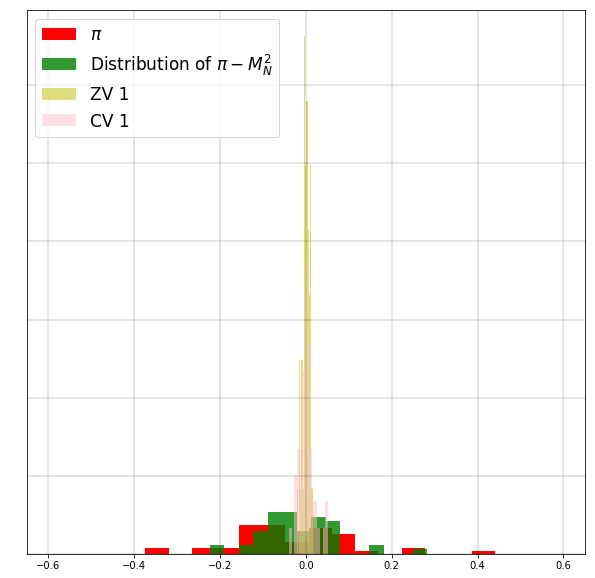

In [30]:
plt.figure(figsize=(10,10))
plt.hist(P_test,15, facecolor='r', density=True, alpha=1, label=r"$\pi$")

plt.hist((P_test-M_test.sum(axis=0)),15, density=True, facecolor='g', alpha=0.8, label="Distribution of $\pi - M^2_N$")

plt.hist(res_zv_1,15, facecolor='y', density=True, alpha=0.5, label="ZV 1")
# plt.hist(res_zv_2,15, facecolor='b', density=True, alpha=0.5, label="ZV 2")
plt.hist(res_cv_1,15, facecolor='pink', density=True, alpha=0.5, label="CV 1")
# plt.hist(res_cv_2,15, facecolor='black', density=True, alpha=0.5, label="CV 2")

plt.legend(loc=2, prop={'size': 17})
plt.grid(linestyle='-', linewidth=0.2, color='black')
plt.tick_params(axis='y',color = 'w', labelcolor = 'w', which='both')
plt.xlim(-0.65, 0.65)
plt.show()

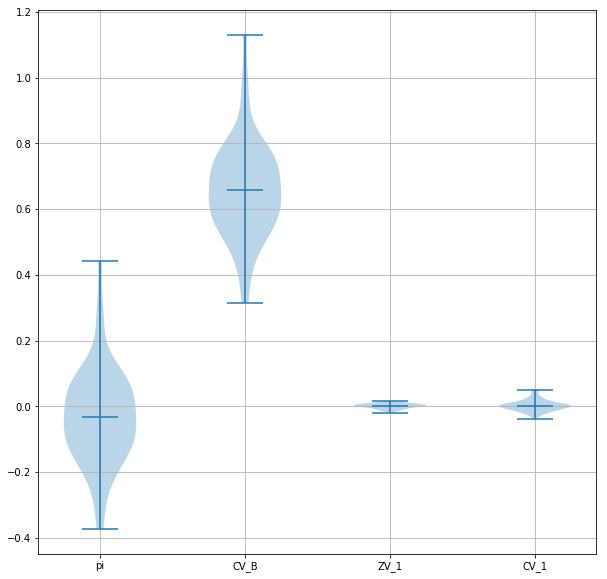

In [36]:
all_data = [P_test]
all_data.append(P_test - M_test[0].sum(axis = 0))
all_data.append(res_zv_1)
# all_data.append(res_zv_2)
all_data.append(res_cv_1)
# all_data.append(res_cv_2)
    
plt.figure(figsize=(10,10))
plt.violinplot(all_data, showmeans=True, showmedians=False)
# plt.title('violin plot')
plt.xticks(np.arange(1,5), ('pi', 'CV_B','ZV_1', 'CV_1'))
plt.grid()
plt.show()

In [111]:
print ('          Variance of Pi = ',P_test.var(ddof = 1))
for i in range(len(k_comb)):
    print ('Variance of new estimator =',(P_test-M_test[:i+1].sum(axis = 0)).var(ddof = 1))
    
for i in range(len(k_comb)):
#     print ('        Variance of CV 1 = ',res_cv_1.var(ddof=1))
    print ('        Variance of CV 2 = ',res_cv_2.var(ddof=1))
    print ('        Variance of ZV 1 = ',res_zv_1.var(ddof=1))
    print ('        Variance of ZV 2 = ',res_zv_2.var(ddof=1))

          Variance of Pi =  0.04031539554577874
Variance of new estimator = 0.009871952236339288
Variance of new estimator = 0.009584098102658766
        Variance of CV 2 =  0.0001377805787611106


AttributeError: 'list' object has no attribute 'var'

In [112]:
P_test

array([-0.09783166,  0.0877711 , -0.01041719,  0.17878906, -0.03219695,
        0.05736603,  0.07462771, -0.13625429, -0.26641601,  0.1231678 ,
        0.06228301,  0.26225033,  0.17815498,  0.49304987, -0.02109261,
       -0.31542413,  0.30846345,  0.18105403, -0.0813687 ,  0.09807821,
       -0.15202723, -0.3441288 ,  0.15030469,  0.3190499 , -0.22384347,
       -0.0274563 ,  0.03467078, -0.03180704,  0.21908692, -0.26318522])

In [113]:
M_test

array([[-4.29065171e-02,  2.90831683e-02,  2.51510720e-02,
         9.63635287e-02, -3.79112747e-02,  3.35186553e-02,
         5.92682305e-02, -5.01699737e-02, -1.62529782e-01,
         3.48697972e-02,  2.72427659e-02,  1.04856487e-01,
         9.96626884e-02,  2.96480411e-01, -9.64954695e-03,
        -1.60328859e-01,  1.76211094e-01,  1.10339279e-01,
        -6.46436753e-02,  4.69725346e-02, -6.97723848e-02,
        -1.89129646e-01,  8.18978868e-02,  1.31255981e-01,
        -8.68382770e-02, -5.95310121e-02, -5.06725303e-03,
         1.08227293e-02,  6.42243661e-02, -1.43675496e-01],
       [-6.35620848e-04, -4.41505484e-03, -3.68343636e-03,
        -2.82951185e-04,  5.18655423e-03,  1.23641143e-04,
         5.27310017e-03, -6.28003500e-03, -3.36080650e-03,
        -2.77251961e-03, -2.77287793e-03,  2.49431733e-03,
        -3.06420152e-03,  2.90064285e-03, -1.83435819e-03,
        -5.63629758e-03, -1.06845563e-03,  7.09822763e-03,
        -1.49964844e-03, -1.92624480e-03,  1.37706673e-